This example solves linear regression with Huber modeled as QP.

Try to predict the median housing price using the other features.
Use a variety of values of gamma input on the command line.

Boston Housing Data
Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

In [11]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card

import sys
import numpy as np
import pandas as pd

In [12]:
m = gp.Container(load_from="boston.gdx")

# Sets
i,headr = m.getSymbols(["i", "headr"])
display(headr.records)

# Parameters
[data] = m.getSymbols(["Data"])
display(data.pivot())

,uni,element_text
0,CRIM,
1,ZN,
2,INDUS,
3,NOX,
4,RM,
5,AGE,
6,DIS,
7,RAD,
8,TAX,
9,PTRATIO,


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CHAS
1,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,0.0
2,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,0.0
3,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,0.0
4,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,0.0
5,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,0.06263,0.0,11.93,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4,0.0
503,0.04527,0.0,11.93,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6,0.0
504,0.06076,0.0,11.93,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9,0.0
505,0.10959,0.0,11.93,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0,0.0


In [13]:
# Standardize data and set up train, test and j in this cell

means = m.addParameter('means',domain=headr)
stddev = m.addParameter('stddev',domain=headr)
means[headr] = Sum(i, data[i,headr])/Card(i)
stddev[headr] = gpm.sqrt(Sum(i, gpm.sqr(data[i,headr]-means[headr]))/Card(i))

sdat = m.addParameter('sdat',domain=[i,headr])
sdat[i,headr] = (data[i,headr] - means[headr])/stddev[headr]

train = m.addSet('train',description='observation number',domain = i) 
train[i] = gp.Number(1).where[i.val <= 450]
# , records=[x for x in range(1, 451)]
test = m.addSet('test',description='observation number', domain = i)
test[i] = ~train[i]
# , records=[x for x in range(451, 507)]
n = m.addSet('n',domain=headr,description='index of independent variables',records=["CRIM", "ZN", "INDUS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "CHAS"])

In [14]:
# Set up huber model and solve in this cell
r = m.addVariable('r','free',domain=i,description='residual')
x = m.addVariable('x','free',domain=n,description='estimates')

b = m.addVariable('b','free')

sigma = m.addParameter('sigma',description="cutoff for quadratic penalty", 
    records=1)

t = m.addVariable('t',domain=i,description='residual l_1 error')

upp = m.addEquation('upp',domain=i) 
upp[train] = sdat[train,"MEDV"] - Sum(n, sdat[train,n]*x[n]) - r[train] - b <= t[train]

low = m.addEquation('low',domain=i) 
low[train] = -t[train] <= sdat[train,"MEDV"] - Sum(n, sdat[train,n]*x[n]) - r[train] - b

hubmod = m.addModel('hubmod',
    equations=[low,upp],
    problem=gp.Problem.QCP,
    sense=gp.Sense.MIN,
    objective=1/2*Sum(train, gpm.sqr(r[train])) + sigma*Sum(train, t[train])
)

x.l[n] = 1 

hubmod.solve(options=gp.Options(qcp="conopt"),output=None)

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalLocal,54.7179099527434,901,915,QCP,CONOPT,0.164


In [15]:
#LEAST SQUARES
ls = m.addVariable('ls', 'free', domain=i)
beta = m.addVariable('betals', 'free', domain=n)
beta0 = m.addVariable('beta0ls', 'free')

ls_const = m.addEquation('lseq', domain=i)
ls_const[train] = (sdat[train,"MEDV"] - Sum(n, sdat[train, n]*beta[n]) - ls[train] - beta0 == 0)

least_s = m.addModel('least_s',
    equations=[ls_const],
    problem=gp.Problem.QCP,
    sense=gp.Sense.MIN,
    objective=1/2*Sum(train, gpm.sqr(ls[train]))
)

least_s.solve(options=gp.Options(qcp="conopt"), output=None)

huber = 0
least_squares = 0

sigma_range = np.linspace(1, 3, 200)

for sig_val in sigma_range:
    sigma = m.addParameter('sigma', records=sig_val)
    hubmod.solve(options=gp.Options(qcp="conopt"), output=None)
    if hubmod.status in [
        gp.ModelStatus.OptimalGlobal, 
        gp.ModelStatus.OptimalLocal
        ]:
        huber = hubmod.objective_value

        if abs(huber - least_s.objective_value) < 1e-4:
            lssigma = sig_val
            print(f"\nMatching Sigma value is: {sig_val}")
            break



Matching Sigma value is: 2.7688442211055277


In [16]:
preds = gp.Parameter(m,'pred',domain=i,description='prediction')
mspe = gp.Parameter(m,'mspe',description='mean sqr prediction error')

solsig = []
solmspe = []

ranges = np.linspace(-1, 5, 300)

for sigma2 in ranges:
    sigma[:] = sigma2
    hubmod.solve(options=gp.Options(qcp="conopt"),output=None)
    if hubmod.status in [
        gp.ModelStatus.OptimalGlobal,
        gp.ModelStatus.OptimalLocal,
    ]:
        preds[test] = Sum(n, x.l[n] * sdat[test, n]) + b.l
        mspe[:] = (1/2 * Sum(test, gpm.sqr(preds[test] - sdat[test, "MEDV"])) / Card(test))
        solsig.append(sigma2)
        solmspe.append(mspe.toValue())

# generate values for comparison of sigma and mspe

[MODEL - WARNING] The solve was interrupted! Solve status: EvaluationInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.
[MODEL - WARNING] The solve was interrupted! Solve status: EvaluationInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


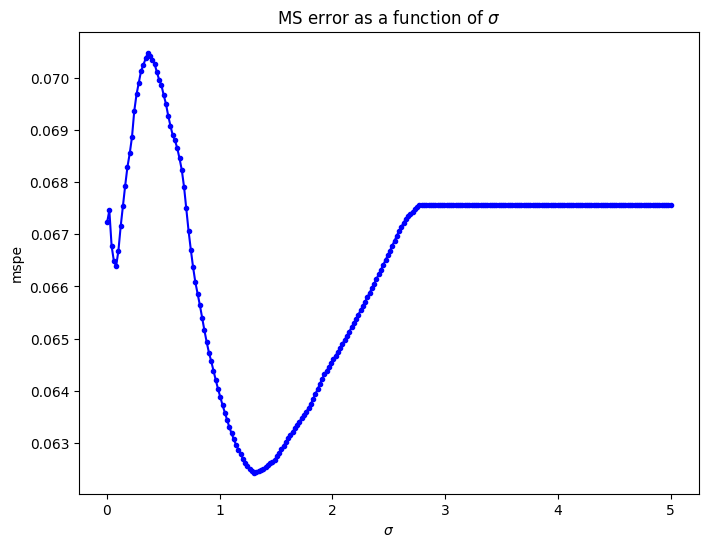

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("MS error as a function of $\\sigma$")
ax.set_xlabel("$\\sigma$")
ax.set_ylabel("mspe")
ax.plot(solsig,solmspe,"b.-");

In [19]:
# display lssigma and mspe sigma
min_mspe = np.argmin(solmspe)
min_sigma = solsig[min_mspe]

print(f"lssigma = {lssigma}, This sigma value makes the huber model the same as the least squares model")

print(f"\nminsigma = {min_sigma}, This sigma value that makes MSPE as small as possible on the test set")

lssigma = 2.7688442211055277, This sigma value makes the huber model the same as the least squares model

minsigma = 1.307692307692308, This sigma value that makes MSPE as small as possible on the test set
